In [1]:
# Test experimental mean

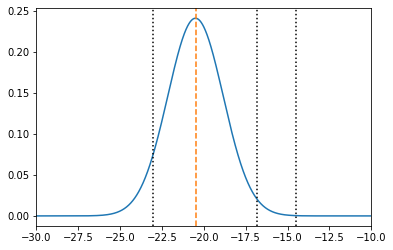

0.0635694947776476 0.9362842738893936 0.00014623133295874586
0.9871541568218497


In [2]:
import am_sim as ams

import matplotlib.pyplot as plt

import numpy as np
from am_sim.model_parameters import low_en_exp_cutoff, high_en_exp_cutoff, low_en_threshold
par = ams.st_par()
par['mu_i'] = -20.5
pop = ams.det_pop(par)
#pop.varphi = np.zeros_like(pop.varphi)
#pop.varphi[[0,3500,-1]] = 100.
#pop.varphi[3500] = 300.
plt.plot(pop.x, pop.varphi)
plt.axvline(low_en_exp_cutoff, ls=':', c='k')
plt.axvline(high_en_exp_cutoff, ls=':', c='k')
plt.axvline(low_en_threshold, ls=':', c='k')
plt.axvline(pop.mean_en_exp(), ls= '--', c='C1')
plt.xlim(-30,-10)
plt.show()

print(pop.r_haff_exp())